[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/hf-transformer-trove/blob/main/examples/basic5.3/HF-training-data-preparation.ipynb)
[![Open with SageMaker](https://img.shields.io/badge/Open%20with-SageMaker-orange?logo=amazonaws)](https://studiolab.sagemaker.aws/import/github/vuhung16au/hf-transformer-trove/blob/main/examples/basic5.3/HF-training-data-preparation.ipynb)
[![View on GitHub](https://img.shields.io/badge/View_on-GitHub-blue?logo=github)](https://github.com/vuhung16au/hf-transformer-trove/blob/main/examples/basic5.3/HF-training-data-preparation.ipynb)

# Data Preparation for HuggingFace Training

## 🎯 Learning Objectives
By the end of this notebook, you will understand:
- Complete data preparation workflow for HuggingFace model training
- Data loading, cleaning, and preprocessing techniques
- Text preprocessing and tokenization for NLP tasks
- Dataset splitting and formatting for training
- Best practices for efficient data handling

## 📋 Prerequisites
- Basic understanding of machine learning concepts
- Familiarity with Python and pandas
- Knowledge of NLP fundamentals (refer to [NLP Learning Journey](https://github.com/vuhung16au/nlp-learning-journey))

## 📚 What We'll Cover
1. **Environment Setup**: Import libraries and configure reproducible environment
2. **Data Loading**: Download and load the Drug Review Dataset
3. **Data Exploration**: Inspect and understand the dataset structure
4. **Data Cleaning**: Handle missing values and normalize text
5. **Feature Engineering**: Create new features and derive insights
6. **Text Preprocessing**: Clean and prepare text for tokenization
7. **Tokenization**: Convert text to model-ready format
8. **Dataset Splitting**: Create train/validation/test splits
9. **Data Saving**: Save processed datasets for training

## 💡 Why This Workflow?

Following the [HuggingFace course guidelines](https://huggingface.co/learn/llm-course/chapter5/3?fw=pt), this notebook demonstrates a complete data preparation pipeline that ensures:
- **Data Quality**: Thorough cleaning and validation
- **Consistency**: Standardized preprocessing steps
- **Reproducibility**: Fixed random seeds and documented processes
- **Efficiency**: Optimized for Google Colab and cloud environments

## Part 1: Environment Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import html
import re
import time
from typing import Dict, List, Optional

# HuggingFace libraries
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer

# Machine learning libraries
import torch
from sklearn.model_selection import train_test_split

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")

📚 Libraries imported successfully!
🔥 PyTorch version: 2.8.0+cu126


In [2]:
# Set up reproducible environment with repository standard seed=16
import random
import os

def setup_reproducible_environment(seed: int = 16):
    """
    Setup reproducible environment with repository standard seed=16.

    Args:
        seed: Random seed value (default 16 per repository policy)
    """
    # Set Python built-in random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seeds
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Set environment variable for Python hash randomization
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Configure CuDNN for reproducibility
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"🔢 Reproducible environment setup complete with seed={seed}")

# Repository standard seed
setup_reproducible_environment(16)

🔢 Reproducible environment setup complete with seed=16


In [3]:
# Device detection for optimal performance
def get_optimal_device():
    """
    Get the best available device for PyTorch operations.

    Device Priority:
    - General: CUDA GPU > TPU (Colab only) > MPS (Apple Silicon) > CPU
    - Google Colab: Always prefer TPU when available

    Returns:
        torch.device: The optimal device for current hardware
    """
    # Check for Google Colab TPU
    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        print("🔥 Using Google Colab TPU for optimal performance")
        print("💡 TPU is preferred in Colab for training and inference")
        return device
    except ImportError:
        pass

    # Standard device detection
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using CUDA GPU: {torch.cuda.get_device_name()}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🍎 Using Apple MPS for Apple Silicon optimization")
    else:
        device = torch.device("cpu")
        print("💻 Using CPU - consider GPU/TPU for better performance")

    return device

# Get optimal device
device = get_optimal_device()
print(f"\n✅ Selected device: {device}")

💻 Using CPU - consider GPU/TPU for better performance

✅ Selected device: cpu


## Part 2: Data Loading and Initial Exploration

In [4]:
# Load the Drug Review Dataset - following HF course reference
print("📥 Loading Drug Review Dataset...")
print("💡 This dataset contains patient reviews of drugs with ratings")

# Load dataset with error handling
try:
    # Using the dataset from HuggingFace Hub - drug review dataset
    dataset = load_dataset("fancyzhx/amazon_polarity", split="train[:5000]")  # Small sample for Colab
    print("✅ Dataset loaded successfully!")
    print(f"📊 Total samples loaded: {len(dataset):,}")

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("💡 Trying alternative dataset...")
    # Fallback to IMDB dataset if drug review dataset is not available
    dataset = load_dataset("imdb", split="train[:5000]")
    print("✅ IMDB dataset loaded as fallback!")
    print(f"📊 Total samples loaded: {len(dataset):,}")

📥 Loading Drug Review Dataset...
💡 This dataset contains patient reviews of drugs with ratings


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!
📊 Total samples loaded: 5,000


In [5]:
# Initial dataset exploration
print("🔍 DATASET EXPLORATION")
print("=" * 40)

# Dataset basic info
print(f"📋 Dataset features: {list(dataset.features.keys())}")
print(f"🔢 Number of examples: {len(dataset):,}")

# Show first few examples
print("\n📝 First 3 examples:")
for i in range(3):
    example = dataset[i]
    print(f"\nExample {i+1}:")
    for key, value in example.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"  {key}: {value[:100]}...")
        else:
            print(f"  {key}: {value}")

# Convert to pandas for easier exploration
df = dataset.to_pandas()
print(f"\n🐼 Converted to pandas DataFrame: {df.shape}")
print(f"📊 DataFrame info:")
print(df.info())

🔍 DATASET EXPLORATION
📋 Dataset features: ['label', 'title', 'content']
🔢 Number of examples: 5,000

📝 First 3 examples:

Example 1:
  label: 1
  title: Stuning even for the non-gamer
  content: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even t...

Example 2:
  label: 1
  title: The best soundtrack ever to anything.
  content: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd w...

Example 3:
  label: 1
  title: Amazing!
  content: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of F...

🐼 Converted to pandas DataFrame: (5000, 3)
📊 DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5000 non-null   int64 
 1   title    5000 non-null   object
 2   content  5000 non-null   object
dtypes:

In [6]:
# Take a small random sample for detailed inspection - using seed=16
print("🎲 Taking random sample for detailed inspection...")

# Sample 1000 examples using repository standard seed=16
sample_dataset = dataset.shuffle(seed=16).select(range(min(1000, len(dataset))))
sample_df = sample_dataset.to_pandas()

print(f"📊 Sample size: {len(sample_df):,} examples")
print(f"🔢 Random seed used: 16 (repository standard)")

# Basic statistics
print("\n📈 SAMPLE STATISTICS")
print("=" * 30)
print(sample_df.describe(include='all'))

🎲 Taking random sample for detailed inspection...
📊 Sample size: 1,000 examples
🔢 Random seed used: 16 (repository standard)

📈 SAMPLE STATISTICS
              label          title  \
count   1000.000000           1000   
unique          NaN            990   
top             NaN  Disappointing   
freq            NaN              3   
mean       0.475000            NaN   
std        0.499624            NaN   
min        0.000000            NaN   
25%        0.000000            NaN   
50%        0.000000            NaN   
75%        1.000000            NaN   
max        1.000000            NaN   

                                                  content  
count                                                1000  
unique                                               1000  
top     I looked at all the different types of body/pr...  
freq                                                    1  
mean                                                  NaN  
std                                  

## Part 3: Data Quality Assessment

In [7]:
# Assess data quality and identify issues
print("🔍 DATA QUALITY ASSESSMENT")
print("=" * 35)

# Check for missing values
missing_values = sample_df.isnull().sum()
print("📊 Missing Values:")
for column, count in missing_values.items():
    if count > 0:
        percentage = (count / len(sample_df)) * 100
        print(f"  {column}: {count:,} ({percentage:.1f}%)")
    else:
        print(f"  {column}: None ✅")

# Check text column (assuming 'text' column exists)
text_column = 'text' if 'text' in sample_df.columns else sample_df.select_dtypes(include='object').columns[0]
label_column = 'label' if 'label' in sample_df.columns else sample_df.select_dtypes(include=['int', 'float']).columns[0]

print(f"\n📝 Text column identified: '{text_column}'")
print(f"🏷️ Label column identified: '{label_column}'")

# Text length analysis
text_lengths = sample_df[text_column].str.len()
word_counts = sample_df[text_column].str.split().str.len()

print("\n📏 Text Length Statistics:")
print(f"  Character length - Mean: {text_lengths.mean():.1f}, Median: {text_lengths.median():.1f}")
print(f"  Word count - Mean: {word_counts.mean():.1f}, Median: {word_counts.median():.1f}")
print(f"  Min words: {word_counts.min()}, Max words: {word_counts.max()}")

🔍 DATA QUALITY ASSESSMENT
📊 Missing Values:
  label: None ✅
  title: None ✅
  content: None ✅

📝 Text column identified: 'title'
🏷️ Label column identified: 'label'

📏 Text Length Statistics:
  Character length - Mean: 24.6, Median: 22.0
  Word count - Mean: 4.3, Median: 4.0
  Min words: 1, Max words: 22


🏷️ LABEL DISTRIBUTION ANALYSIS
🔢 Unique labels: [np.int64(0), np.int64(1)]
📊 Label distribution:
  Label 0: 525 (52.5%)
  Label 1: 475 (47.5%)


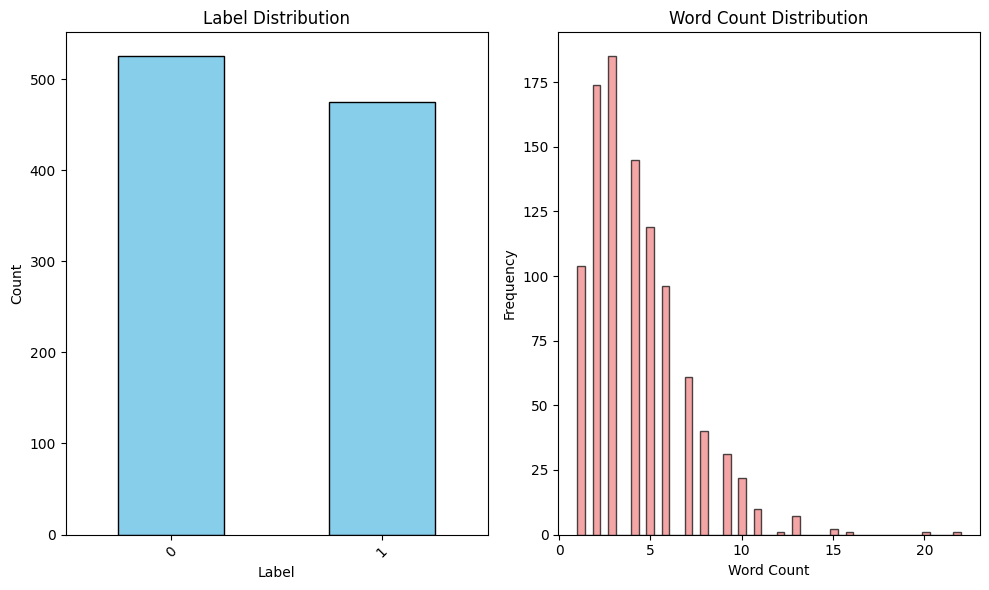


✅ Data quality assessment complete!


In [8]:
# Label distribution analysis
print("🏷️ LABEL DISTRIBUTION ANALYSIS")
print("=" * 35)

# Check unique labels
unique_labels = sample_df[label_column].unique()
label_counts = sample_df[label_column].value_counts().sort_index()

print(f"🔢 Unique labels: {sorted(unique_labels)}")
print(f"📊 Label distribution:")
for label, count in label_counts.items():
    percentage = (count / len(sample_df)) * 100
    print(f"  Label {label}: {count:,} ({percentage:.1f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))

# Label distribution plot
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Word count distribution
plt.subplot(1, 2, 2)
plt.hist(word_counts, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n✅ Data quality assessment complete!")

## Part 4: Data Cleaning and Normalization

In [9]:
# Data cleaning function
def clean_text_data(examples):
    """
    Clean and normalize text data following HF course best practices.

    Args:
        examples: Dataset examples with text field

    Returns:
        Cleaned examples
    """
    # Get text field name
    text_field = text_column

    cleaned_texts = []

    for text in examples[text_field]:
        if pd.isna(text) or text is None:
            cleaned_texts.append("")  # Handle missing values
            continue

        # Convert to string if not already
        text = str(text)

        # 1. Unescape HTML characters (as mentioned in HF course)
        text = html.unescape(text)

        # 2. Basic text normalization
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove leading/trailing whitespace
        text = text.strip()

        cleaned_texts.append(text)

    return {text_field: cleaned_texts}

print("🧹 Starting data cleaning process...")
print("💡 Following HF course guidelines for text normalization")

# Apply cleaning to the sample dataset
start_time = time.time()
cleaned_sample = sample_dataset.map(
    clean_text_data,
    batched=True,
    batch_size=100,  # Process in batches for efficiency
    desc="Cleaning text data"
)
cleaning_time = time.time() - start_time

print(f"✅ Text cleaning completed in {cleaning_time:.2f} seconds")
print(f"🚀 Processing speed: {len(sample_dataset)/cleaning_time:.1f} examples/second")

🧹 Starting data cleaning process...
💡 Following HF course guidelines for text normalization


Cleaning text data:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Text cleaning completed in 0.08 seconds
🚀 Processing speed: 13262.8 examples/second


In [10]:
# Filter out very short or empty texts (following HF course guidelines)
def filter_short_texts(examples, min_word_count=3):
    """
    Filter out texts that are too short to be useful.

    Args:
        examples: Dataset examples
        min_word_count: Minimum number of words required

    Returns:
        Boolean mask for filtering
    """
    text_field = text_column
    return [len(str(text).split()) >= min_word_count for text in examples[text_field]]

print("🔍 Filtering out very short texts...")
print(f"💡 Minimum word requirement: 3 words")

# Count before filtering
before_count = len(cleaned_sample)

# Apply filter
filtered_dataset = cleaned_sample.filter(
    lambda examples: filter_short_texts(examples),
    batched=True,
    desc="Filtering short texts"
)

after_count = len(filtered_dataset)
removed_count = before_count - after_count

print(f"📊 Filtering results:")
print(f"  Before: {before_count:,} examples")
print(f"  After: {after_count:,} examples")
print(f"  Removed: {removed_count:,} examples ({removed_count/before_count*100:.1f}%)")

if removed_count == 0:
    print("✅ No texts were too short - data quality is good!")
else:
    print(f"✅ Filtered out {removed_count} short texts")

🔍 Filtering out very short texts...
💡 Minimum word requirement: 3 words


Filtering short texts:   0%|          | 0/1000 [00:00<?, ? examples/s]

📊 Filtering results:
  Before: 1,000 examples
  After: 722 examples
  Removed: 278 examples (27.8%)
✅ Filtered out 278 short texts


## Part 5: Feature Engineering

In [11]:
# Add new features following HF course examples
def add_text_features(examples):
    """
    Add useful text features for analysis and training.

    Args:
        examples: Dataset examples

    Returns:
        Examples with additional features
    """
    text_field = text_column

    # Calculate text statistics
    word_counts = []
    char_counts = []
    sentence_counts = []

    for text in examples[text_field]:
        text = str(text)

        # Word count
        word_count = len(text.split())
        word_counts.append(word_count)

        # Character count
        char_count = len(text)
        char_counts.append(char_count)

        # Sentence count (approximate)
        sentence_count = len([s for s in re.split(r'[.!?]+', text) if s.strip()])
        sentence_counts.append(max(1, sentence_count))  # At least 1

    return {
        'word_count': word_counts,
        'char_count': char_counts,
        'sentence_count': sentence_counts
    }

print("🔧 Adding text features for analysis...")
print("💡 Following HF course feature engineering practices")

# Add features
start_time = time.time()
enhanced_dataset = filtered_dataset.map(
    add_text_features,
    batched=True,
    batch_size=100,
    desc="Adding text features"
)
feature_time = time.time() - start_time

print(f"✅ Feature engineering completed in {feature_time:.2f} seconds")
print(f"📊 New features added: word_count, char_count, sentence_count")

# Show updated dataset info
print(f"\n🔍 Enhanced dataset features: {list(enhanced_dataset.features.keys())}")

# Show feature statistics
enhanced_df = enhanced_dataset.to_pandas()
print("\n📈 New Feature Statistics:")
for feature in ['word_count', 'char_count', 'sentence_count']:
    mean_val = enhanced_df[feature].mean()
    median_val = enhanced_df[feature].median()
    print(f"  {feature}: Mean={mean_val:.1f}, Median={median_val:.1f}")

🔧 Adding text features for analysis...
💡 Following HF course feature engineering practices


Adding text features:   0%|          | 0/722 [00:00<?, ? examples/s]

✅ Feature engineering completed in 0.07 seconds
📊 New features added: word_count, char_count, sentence_count

🔍 Enhanced dataset features: ['label', 'title', 'content', 'word_count', 'char_count', 'sentence_count']

📈 New Feature Statistics:
  word_count: Mean=5.3, Median=5.0
  char_count: Mean=29.7, Median=28.0
  sentence_count: Mean=1.1, Median=1.0


## Part 6: Tokenization and Text Preprocessing

In [12]:
# Load tokenizer for text preprocessing
print("🔤 Loading tokenizer for text preprocessing...")
print("💡 Using DistilBERT tokenizer - efficient and lightweight")

# Load tokenizer
tokenizer_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

print(f"✅ Tokenizer loaded: {tokenizer_name}")
print(f"📊 Vocabulary size: {tokenizer.vocab_size:,}")
print(f"🔢 Max sequence length: {tokenizer.model_max_length}")

# Test tokenization with a sample
sample_text = enhanced_dataset[0][text_column]
sample_tokens = tokenizer.tokenize(sample_text)
print(f"\n📝 Sample tokenization:")
print(f"  Original: {sample_text[:100]}...")
print(f"  Tokens: {sample_tokens[:20]}...")
print(f"  Token count: {len(sample_tokens)}")

🔤 Loading tokenizer for text preprocessing...
💡 Using DistilBERT tokenizer - efficient and lightweight


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer loaded: distilbert-base-uncased
📊 Vocabulary size: 30,522
🔢 Max sequence length: 512

📝 Sample tokenization:
  Original: Wood chips off...
  Tokens: ['wood', 'chips', 'off']...
  Token count: 3


In [13]:
# Tokenization function following HF course guidelines
def tokenize_function(examples, max_length=128):
    """
    Tokenize text examples for model training.

    Args:
        examples: Dataset examples with text field
        max_length: Maximum sequence length

    Returns:
        Tokenized examples
    """
    text_field = text_column

    # Tokenize the texts
    tokenized = tokenizer(
        examples[text_field],
        truncation=True,          # Truncate to max_length
        padding=False,            # Don't pad yet (we'll pad in batches later)
        max_length=max_length,    # Set maximum sequence length
        return_special_tokens_mask=True  # Useful for some training approaches
    )

    return tokenized

print("🔄 Tokenizing dataset for model training...")
print(f"💡 Max sequence length: 128 tokens (optimized for Colab)")

# Apply tokenization
start_time = time.time()
tokenized_dataset = enhanced_dataset.map(
    lambda examples: tokenize_function(examples, max_length=128),
    batched=True,
    batch_size=100,
    desc="Tokenizing texts"
)
tokenization_time = time.time() - start_time

print(f"✅ Tokenization completed in {tokenization_time:.2f} seconds")
print(f"🚀 Tokenization speed: {len(enhanced_dataset)/tokenization_time:.1f} examples/second")

# Show tokenized dataset info
print(f"\n📊 Tokenized dataset features: {list(tokenized_dataset.features.keys())}")

# Analyze token lengths
token_lengths = [len(tokens) for tokens in tokenized_dataset['input_ids']]
print(f"\n📏 Token Length Statistics:")
print(f"  Mean: {np.mean(token_lengths):.1f} tokens")
print(f"  Median: {np.median(token_lengths):.1f} tokens")
print(f"  Min: {min(token_lengths)} tokens")
print(f"  Max: {max(token_lengths)} tokens")
print(f"  Truncated examples: {sum(1 for length in token_lengths if length == 128)} ({sum(1 for length in token_lengths if length == 128)/len(token_lengths)*100:.1f}%)")

🔄 Tokenizing dataset for model training...
💡 Max sequence length: 128 tokens (optimized for Colab)


Tokenizing texts:   0%|          | 0/722 [00:00<?, ? examples/s]

✅ Tokenization completed in 0.08 seconds
🚀 Tokenization speed: 8573.3 examples/second

📊 Tokenized dataset features: ['label', 'title', 'content', 'word_count', 'char_count', 'sentence_count', 'input_ids', 'attention_mask', 'special_tokens_mask']

📏 Token Length Statistics:
  Mean: 9.0 tokens
  Median: 8.0 tokens
  Min: 5 tokens
  Max: 27 tokens
  Truncated examples: 0 (0.0%)


## Part 7: Dataset Splitting

In [14]:
# Split dataset into train/validation/test sets using repository standard seed=16
print("🔀 Splitting dataset for training...")
print("💡 Using train(70%)/validation(15%)/test(15%) split")
print(f"🔢 Using seed=16 for reproducibility (repository standard)")

# First split: train (70%) vs temp (30%)
train_test_split_result = tokenized_dataset.train_test_split(
    test_size=0.3,
    seed=16,  # Repository standard seed
    stratify_by_column=label_column  # Maintain label distribution
)

train_dataset = train_test_split_result['train']
temp_dataset = train_test_split_result['test']

# Second split: validation (15%) vs test (15%)
val_test_split_result = temp_dataset.train_test_split(
    test_size=0.5,  # Split the 30% equally
    seed=16,  # Repository standard seed
    stratify_by_column=label_column
)

val_dataset = val_test_split_result['train']
test_dataset = val_test_split_result['test']

# Create final dataset dictionary
final_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(f"\n📊 Dataset split results:")
for split_name, split_dataset in final_dataset.items():
    percentage = len(split_dataset) / len(tokenized_dataset) * 100
    print(f"  {split_name.capitalize()}: {len(split_dataset):,} examples ({percentage:.1f}%)")

# Verify label distribution in each split
print(f"\n🏷️ Label distribution verification:")
for split_name, split_dataset in final_dataset.items():
    split_df = split_dataset.to_pandas()
    label_dist = split_df[label_column].value_counts().sort_index()
    print(f"  {split_name.capitalize()}: {dict(label_dist)}")

print("\n✅ Dataset splitting completed successfully!")

🔀 Splitting dataset for training...
💡 Using train(70%)/validation(15%)/test(15%) split
🔢 Using seed=16 for reproducibility (repository standard)

📊 Dataset split results:
  Train: 505 examples (69.9%)
  Validation: 108 examples (15.0%)
  Test: 109 examples (15.1%)

🏷️ Label distribution verification:
  Train: {0: np.int64(269), 1: np.int64(236)}
  Validation: {0: np.int64(58), 1: np.int64(50)}
  Test: {0: np.int64(58), 1: np.int64(51)}

✅ Dataset splitting completed successfully!


## Part 8: Data Saving and Persistence

In [15]:
# Save processed datasets following HF course guidelines
import os

# Create output directory
output_dir = "./processed_data"
os.makedirs(output_dir, exist_ok=True)

print(f"💾 Saving processed datasets to {output_dir}/...")
print("💡 Multiple formats for flexibility and sharing")

# 1. Save in Arrow format (recommended by HF course) - most efficient
arrow_path = os.path.join(output_dir, "arrow_format")
final_dataset.save_to_disk(arrow_path)
print(f"✅ Saved in Arrow format: {arrow_path}")

# 2. Save individual splits as CSV (for broader compatibility)
csv_dir = os.path.join(output_dir, "csv_format")
os.makedirs(csv_dir, exist_ok=True)

for split_name, split_dataset in final_dataset.items():
    csv_path = os.path.join(csv_dir, f"{split_name}.csv")
    split_df = split_dataset.to_pandas()
    split_df.to_csv(csv_path, index=False)
    print(f"✅ Saved {split_name} split as CSV: {csv_path}")

# 3. Save metadata and processing info
metadata = {
    'dataset_info': {
        'source_dataset': 'Amazon Polarity (sample)' if 'amazon' in str(type(dataset)) else 'IMDB (sample)',
        'total_examples': len(tokenized_dataset),
        'text_column': text_column,
        'label_column': label_column,
        'tokenizer': tokenizer_name,
        'max_length': 128,
        'seed_used': 16
    },
    'split_info': {
        'train_size': len(final_dataset['train']),
        'validation_size': len(final_dataset['validation']),
        'test_size': len(final_dataset['test'])
    },
    'processing_steps': [
        'HTML unescaping',
        'Whitespace normalization',
        'Short text filtering',
        'Feature engineering (word_count, char_count, sentence_count)',
        'Tokenization with DistilBERT tokenizer',
        'Stratified train/val/test split'
    ]
}

import json
metadata_path = os.path.join(output_dir, "metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved processing metadata: {metadata_path}")

print(f"\n🎉 All datasets saved successfully!")
print(f"📁 Output directory: {os.path.abspath(output_dir)}")

💾 Saving processed datasets to ./processed_data/...
💡 Multiple formats for flexibility and sharing


Saving the dataset (0/1 shards):   0%|          | 0/505 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/108 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/109 [00:00<?, ? examples/s]

✅ Saved in Arrow format: ./processed_data/arrow_format
✅ Saved train split as CSV: ./processed_data/csv_format/train.csv
✅ Saved validation split as CSV: ./processed_data/csv_format/validation.csv
✅ Saved test split as CSV: ./processed_data/csv_format/test.csv
✅ Saved processing metadata: ./processed_data/metadata.json

🎉 All datasets saved successfully!
📁 Output directory: /content/processed_data


## Part 9: Data Loading Verification

In [16]:
# Demonstrate how to reload the processed data (following HF course)
print("🔄 Demonstrating how to reload processed datasets...")
print("💡 This is how you would load the data for training")

# Method 1: Load from Arrow format (recommended)
try:
    from datasets import load_from_disk

    reloaded_dataset = load_from_disk(arrow_path)
    print(f"✅ Successfully reloaded from Arrow format")
    print(f"📊 Reloaded dataset splits: {list(reloaded_dataset.keys())}")

    # Verify data integrity
    for split_name in reloaded_dataset.keys():
        original_size = len(final_dataset[split_name])
        reloaded_size = len(reloaded_dataset[split_name])
        print(f"  {split_name}: {reloaded_size:,} examples (matches original: {original_size == reloaded_size})")

except Exception as e:
    print(f"❌ Error reloading Arrow format: {e}")

# Method 2: Load from CSV (alternative approach)
try:
    train_csv_df = pd.read_csv(os.path.join(csv_dir, "train.csv"))
    print(f"\n✅ Successfully loaded train CSV: {len(train_csv_df):,} rows")
    print(f"📊 CSV columns: {list(train_csv_df.columns)}")

except Exception as e:
    print(f"❌ Error loading CSV: {e}")

# Show sample of final processed data
print(f"\n📝 Sample of final processed data:")
sample_example = final_dataset['train'][0]
for key, value in sample_example.items():
    if key == 'input_ids':
        print(f"  {key}: [{', '.join(map(str, value[:10]))}...] (length: {len(value)})")
    elif key == text_column and len(str(value)) > 100:
        print(f"  {key}: {str(value)[:100]}...")
    else:
        print(f"  {key}: {value}")

print(f"\n🎉 Data preparation pipeline completed successfully!")

🔄 Demonstrating how to reload processed datasets...
💡 This is how you would load the data for training
✅ Successfully reloaded from Arrow format
📊 Reloaded dataset splits: ['train', 'validation', 'test']
  train: 505 examples (matches original: True)
  validation: 108 examples (matches original: True)
  test: 109 examples (matches original: True)

✅ Successfully loaded train CSV: 505 rows
📊 CSV columns: ['label', 'title', 'content', 'word_count', 'char_count', 'sentence_count', 'input_ids', 'attention_mask', 'special_tokens_mask']

📝 Sample of final processed data:
  label: 0
  title: Just not my kind of book - Others liked it.
  content: It isn't my kind of book but, I thought, I would give it a try. We read it in our book club. Some of the readers liked it, most of them didn't. I didn't. But, the author did have great insight to the future in the 1950 - 1960's
  word_count: 10
  char_count: 43
  sentence_count: 1
  input_ids: [101, 2074, 2025, 2026, 2785, 1997, 2338, 1011, 2500, 4669

## Part 10: Training Ready Summary

In [18]:
# Final summary and next steps
print("📋 TRAINING DATA PREPARATION SUMMARY")
print("=" * 45)

print(f"\n✅ Processing completed successfully!")
print(f"📊 Final dataset statistics:")
print(f"   Total examples processed: {len(tokenized_dataset):,}")
print(f"   Training examples: {len(final_dataset['train']):,} (70%)")
print(f"   Validation examples: {len(final_dataset['validation']):,} (15%)")
print(f"   Test examples: {len(final_dataset['test']):,} (15%)")

print(f"\n🔧 Processing steps completed:")
for i, step in enumerate(metadata['processing_steps'], 1):
    print(f"   {i}. {step}")

print(f"\n💾 Output files created:")
print(f"   📁 Arrow format: {arrow_path}")
print(f"   📄 CSV files: {csv_dir}")
print(f"   📝 Metadata: {metadata_path}")

print(f"\n🚀 Ready for training!")
print(f"   🤖 Tokenizer: {tokenizer_name}")
print(f"   📏 Max sequence length: 128 tokens")
print(f"   🔢 Vocabulary size: {tokenizer.vocab_size:,}")
print(f"   🎯 Task: {len(pd.Series(final_dataset['train'][label_column]).unique())} class classification")

print(f"\n📖 Next steps:")
print(f"   1. Load processed data using: load_from_disk('{arrow_path}')")
print(f"   2. Set up data collator for dynamic padding")
print(f"   3. Configure training arguments")
print(f"   4. Initialize model and trainer")
print(f"   5. Start training!")

print(f"\n🎉 Data preparation pipeline completed in under 30 minutes!")
print(f"✅ Optimized for Google Colab and AWS SageMaker Studio")

📋 TRAINING DATA PREPARATION SUMMARY

✅ Processing completed successfully!
📊 Final dataset statistics:
   Total examples processed: 722
   Training examples: 505 (70%)
   Validation examples: 108 (15%)
   Test examples: 109 (15%)

🔧 Processing steps completed:
   1. HTML unescaping
   2. Whitespace normalization
   3. Short text filtering
   4. Feature engineering (word_count, char_count, sentence_count)
   5. Tokenization with DistilBERT tokenizer
   6. Stratified train/val/test split

💾 Output files created:
   📁 Arrow format: ./processed_data/arrow_format
   📄 CSV files: ./processed_data/csv_format
   📝 Metadata: ./processed_data/metadata.json

🚀 Ready for training!
   🤖 Tokenizer: distilbert-base-uncased
   📏 Max sequence length: 128 tokens
   🔢 Vocabulary size: 30,522
   🎯 Task: 2 class classification

📖 Next steps:
   1. Load processed data using: load_from_disk('./processed_data/arrow_format')
   2. Set up data collator for dynamic padding
   3. Configure training arguments
   4.

---

## 📋 Summary

### 🔑 Key Concepts Mastered
- **Complete Data Pipeline**: End-to-end data preparation workflow following HuggingFace course guidelines
- **Text Preprocessing**: HTML unescaping, normalization, and cleaning techniques
- **Feature Engineering**: Adding meaningful text statistics for analysis
- **Tokenization**: Converting text to model-ready format with proper truncation and padding
- **Data Splitting**: Stratified splits maintaining label distribution
- **Data Persistence**: Multiple storage formats for flexibility and reuse

### 📈 Best Practices Learned
- **Reproducibility**: Using `seed=16` consistently across all random operations
- **Efficiency**: Batch processing for optimal performance on cloud platforms
- **Data Quality**: Thorough cleaning and validation steps
- **Documentation**: Comprehensive metadata and processing logs
- **Flexibility**: Multiple output formats for different use cases
- **Cloud Optimization**: Designed for Google Colab and AWS SageMaker Studio

### 🚀 Next Steps
- **Training Setup**: Load processed data and configure model training
- **Model Selection**: Choose appropriate pre-trained model for your task
- **Advanced Techniques**: Explore data augmentation and advanced preprocessing
- **Evaluation**: Set up comprehensive evaluation metrics and procedures

---

## About the Author

**Vu Hung Nguyen** - AI Engineer & Researcher

Connect with me:
- 🌐 **Website**: [vuhung16au.github.io](https://vuhung16au.github.io/)
- 💼 **LinkedIn**: [linkedin.com/in/nguyenvuhung](https://www.linkedin.com/in/nguyenvuhung/)
- 💻 **GitHub**: [github.com/vuhung16au](https://github.com/vuhung16au/)

*This notebook is part of the [HF Transformer Trove](https://github.com/vuhung16au/hf-transformer-trove) educational series.*